In [1]:
import pandas as pd
pd.set_option('display.max_rows', 10000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import torch
import gpytorch
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,Matern,ConstantKernel
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
#%%

# %%
# INDOORS 1 SUN
file = pd.ExcelFile('Indoor MPP_20230608-temp 65C-1sun_110C annealing Temp (1).xlsx', engine='openpyxl')# the whole excel file 
sn = file.sheet_names # sheets that are the excel file 
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl') # read the data from the first sheet 

temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy() #take the temperature from the row Annealing temperature of column Parameters and convert it to numpy
temperature = temperature[2,2:] # take everything from temperature starting from the third row and the third column
 
devices = data_frame.columns.to_numpy() # take the devices from the data and convert them to numpy
 
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:] #excluding the first two elements

time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl') # read the data from the last sheet

time_series_df = time_series_df.drop(index =[0]) # drop the first row (einheiten)
time = time_series_df.iloc[:,0] # take the time from the first column
 
# print(time)
time_series_0_65_sun = []
for i in range (temperature.shape[0]):
    time_series_0_65_sun.append(time_series_df.iloc[:,2+i*3]) ### for every device take the impp (optimal current output that the solar panel can generate when it is operating at its maximum power point)

time_series_0_65_sun = np.array(time_series_0_65_sun) # convert it to array [shape(24, 4001)]


# %%
# OUTDOOR CONDITIONS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')

irradiance = outdoor_conditions['irradiance'] #[shape(4794,)]
rh = outdoor_conditions['rh'] #[shape(4794,)]
 
outdoor_temperature = outdoor_conditions['outdoor_temperature'] #[shape(4794,)]

outdoor_condition_time = outdoor_conditions['time'] #[shape(4794,)] 
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
scaler = MinMaxScaler()
 
# Normalize irradiance column
irradiance_normalized = scaler.fit_transform(outdoor_conditions['irradiance'].values.reshape(-1, 1))

# Normalize rh column
rh_normalized = scaler.fit_transform(outdoor_conditions['rh'].values.reshape(-1, 1))

# Normalize outdoor_temperature column
outdoor_temperature_normalized = scaler.fit_transform(outdoor_conditions['outdoor_temperature'].values.reshape(-1, 1))

# Create a new DataFrame with normalized columns
outdoor_conditions_normalized = pd.DataFrame({
    'irradiance_normalized': irradiance_normalized.flatten(),
    'rh_normalized': rh_normalized.flatten(),
    'outdoor_temperature_normalized': outdoor_temperature_normalized.flatten(),
    'time': outdoor_conditions['time']
})

# Save the normalized DataFrame to a new file
outdoor_conditions_normalized.to_csv('outdoor_conditions_normalized.txt', sep='\t')
outdoor_conditions_normalized=pd.read_csv('outdoor_conditions_normalized.txt', sep='\t')
# %%
# OUTDOOR PANELS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep ='\t')
# outdoor_panels.head()
outdoor_panels_power = [] 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])
outdoor_panels_power = np.array(outdoor_panels_power) #[shape(24, 4794)]

#%%
# Padding


time_series_0_65_sun_shape = time_series_0_65_sun.shape
 
time_series_0_65_sun = np.pad(time_series_0_65_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_0_65_sun.shape[1])),mode='edge')    
    
time_series_0_65_sun = np.reshape(time_series_0_65_sun, ((time_series_0_65_sun.shape[0],time_series_0_65_sun.shape[1],1)))
 
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0],outdoor_panels_power.shape[1],1)))
 

In [3]:
# Calculate average values for time_series_1_sun
time_series_0_65_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_0_65_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_0_65_sun_average[j] = np.mean(time_series_0_65_sun[i-1:i+1], axis=0)
        j += 1
 
     

# Calculate average values for time_series_1_4_sun


# Calculate average values for outdoor_panels_power
outdoor_panels_power_average = np.zeros((12, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i+1) % 2 == 0:
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i-1:i+1], axis=0)
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0 # Set negative values to 0
        b += 1

# Stack the outdoor conditions
outdoor_conditions_stacked = np.stack([outdoor_conditions ] * 12, axis=0)
outdoor_conditions_stacked_2= np.stack([outdoor_conditions] * 20, axis=0)

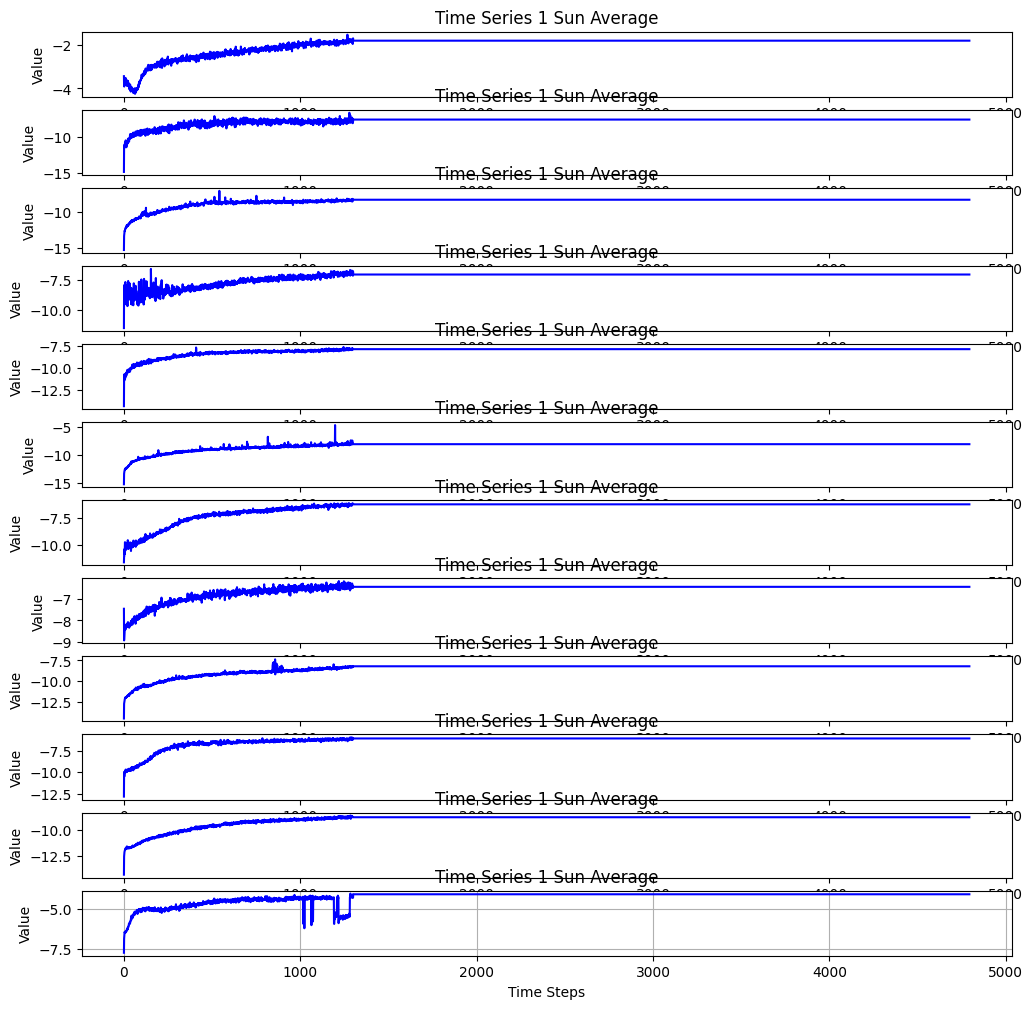

In [4]:
'''for i in range(time_series_1_sun_average.shape[0]):
    if i==7:
     mask = time_series_1_sun_average[i] < -5
     time_series_1_sun_average[i][mask] -= 4'''





import matplotlib.pyplot as plt
fig, axs = plt.subplots(12, 1, figsize=(12, 12))
x = range((time_series_0_65_sun_average.shape[1]))

for i, axs in enumerate(axs.flat):
# Assuming you have time_series_1_sun_average as a 1D numpy array
 

 
 axs.plot(x, time_series_0_65_sun_average[i], color='blue')
 axs.set_xlabel('Time Steps')
 axs.set_ylabel('Value')
 axs.set_title('Time Series 1 Sun Average')
plt.grid(True)
plt.show()

In [5]:
window_size = 30  # Adjust the window size as per your requirements
 


 



fourier_transform = np.fft.fft(time_series_0_65_sun_average, axis=1)
frequencies = np.fft.fftfreq(time_series_0_65_sun_average.shape[1])
magnitudes = np.abs(fourier_transform)
magnitudes_db = 20 * np.log10(magnitudes)


num_samples = 10
time_series_1_sun_average_reshaped = time_series_0_65_sun_average.reshape(12, -1)

 


In [6]:
def exponential_smoothing(series, alpha):
    smoothed_series = [series[0]]  
    for i in range(1, len(series)):
        smoothed_value = alpha * series[i] + (1 - alpha) * smoothed_series[-1]
        smoothed_series.append(smoothed_value)
    return np.array(smoothed_series)
 
alpha = 0.1   
for i in range (time_series_0_65_sun_average.shape[0]):
  time_series_0_65_sun_average[i] = exponential_smoothing(time_series_0_65_sun_average[i], 0.1)
  outdoor_panels_power_average[i] = exponential_smoothing(outdoor_panels_power_average[i], 0.7)

In [7]:
all_new_features = np.concatenate((time_series_0_65_sun_average,magnitudes_db, outdoor_conditions_stacked), axis=2)# concatenate the input for the model
print(all_new_features.shape)
print(outdoor_panels_power_average.shape)

(12, 4794, 7)
(12, 4794, 1)


In [8]:
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C,RationalQuadratic,ExpSineSquared,DotProduct 
from sklearn.preprocessing import RobustScaler, MaxAbsScaler,Normalizer
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.covariance import EllipticEnvelope
 
from sklearn.metrics import mean_squared_error

 
num_samples =all_new_features.shape[0]

 
all_new_features_reshaped = all_new_features.reshape(num_samples, -1)
outdoor_panels_power_average_reshaped = outdoor_panels_power_average.reshape(num_samples, -1)



 
num_folds = 12
 
average_mse_scores1 = []
average_mse_scores2 = []
fold = 0
y_pred1=np.zeros(( 1, 4794))
y_pred2=np.zeros(( 1, 4794))
 
predictions1 = np.zeros((12, 1, 4794))
test1= np.zeros((12, 1, 4794))
predictions2 = np.zeros((12, 1, 4794))
test2 = np.zeros((12, 1, 4794))
 
 

for temp in range(6):
    test_index=[2*temp,2*temp+1]
    train_index = [i for i in range(num_samples) if i not in test_index]
    print(test_index)
    print(train_index )
     
    X_train, X_test = all_new_features_reshaped [train_index], all_new_features_reshaped [test_index]
    y_train, y_test = outdoor_panels_power_average_reshaped[train_index], outdoor_panels_power_average_reshaped[test_index]
    scaler = Normalizer(norm='max')
    X_train= scaler.fit_transform(X_train)
    X_test= scaler.transform(X_test)
    print(X_test.shape)
    
    
     
    kernel =  DotProduct()

    gp = gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=100,normalize_y=True)

 
    gp.fit(X_train, y_train)

 


    y_pred1 = gp.predict(X_test[0].reshape(1, -1))
    y_pred2 = gp.predict(X_test[1].reshape(1, -1))
     

    predictions1[fold] = y_pred1
    predictions2[fold] = y_pred2
    test1[fold] = y_test[0]
    test2[fold] = y_test[1]
    
    # Calculate the Mean Squared Error for the current fold
    error1 = mean_squared_error(y_test[0].reshape(1, -1), y_pred1)
    error2= mean_squared_error(y_test[1].reshape(1, -1), y_pred2)
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error1))
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error2))

    average_mse_scores1.append(error1)
    average_mse_scores2.append(error2)
    fold = fold + 1
    if fold == 6:
        break

# Calculate the average MSE across all folds
average_mse1 = np.mean(average_mse_scores1)
average_mse2 = np.mean(average_mse_scores2)
print(f"Average Mean Squared Error: {average_mse1}")
print(f"Average Mean Squared Error: {average_mse2}")


 
#1.03

[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(2, 33558)


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Fold 1 - Mean Squared Error: 0.8541791898281754
Fold 1 - Mean Squared Error: 1.057493347119301
[2, 3]
[0, 1, 4, 5, 6, 7, 8, 9, 10, 11]
(2, 33558)


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Fold 2 - Mean Squared Error: 0.48827288259351703
Fold 2 - Mean Squared Error: 2.088164641248287
[4, 5]
[0, 1, 2, 3, 6, 7, 8, 9, 10, 11]
(2, 33558)


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Fold 3 - Mean Squared Error: 0.9219473500336677
Fold 3 - Mean Squared Error: 0.2266228562225986
[6, 7]
[0, 1, 2, 3, 4, 5, 8, 9, 10, 11]
(2, 33558)
Fold 4 - Mean Squared Error: 0.2624596420965591
Fold 4 - Mean Squared Error: 1.776502637321395
[8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 10, 11]
(2, 33558)


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Fold 5 - Mean Squared Error: 0.6865212295601355
Fold 5 - Mean Squared Error: 0.8531760927911393
[10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(2, 33558)


C:\Users\benal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\gaussian_process\_gpr.py:629: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Fold 6 - Mean Squared Error: 1.298184871687516
Fold 6 - Mean Squared Error: 1.2291854017151187
Average Mean Squared Error: 0.7519275276332618
Average Mean Squared Error: 1.2051908294029732


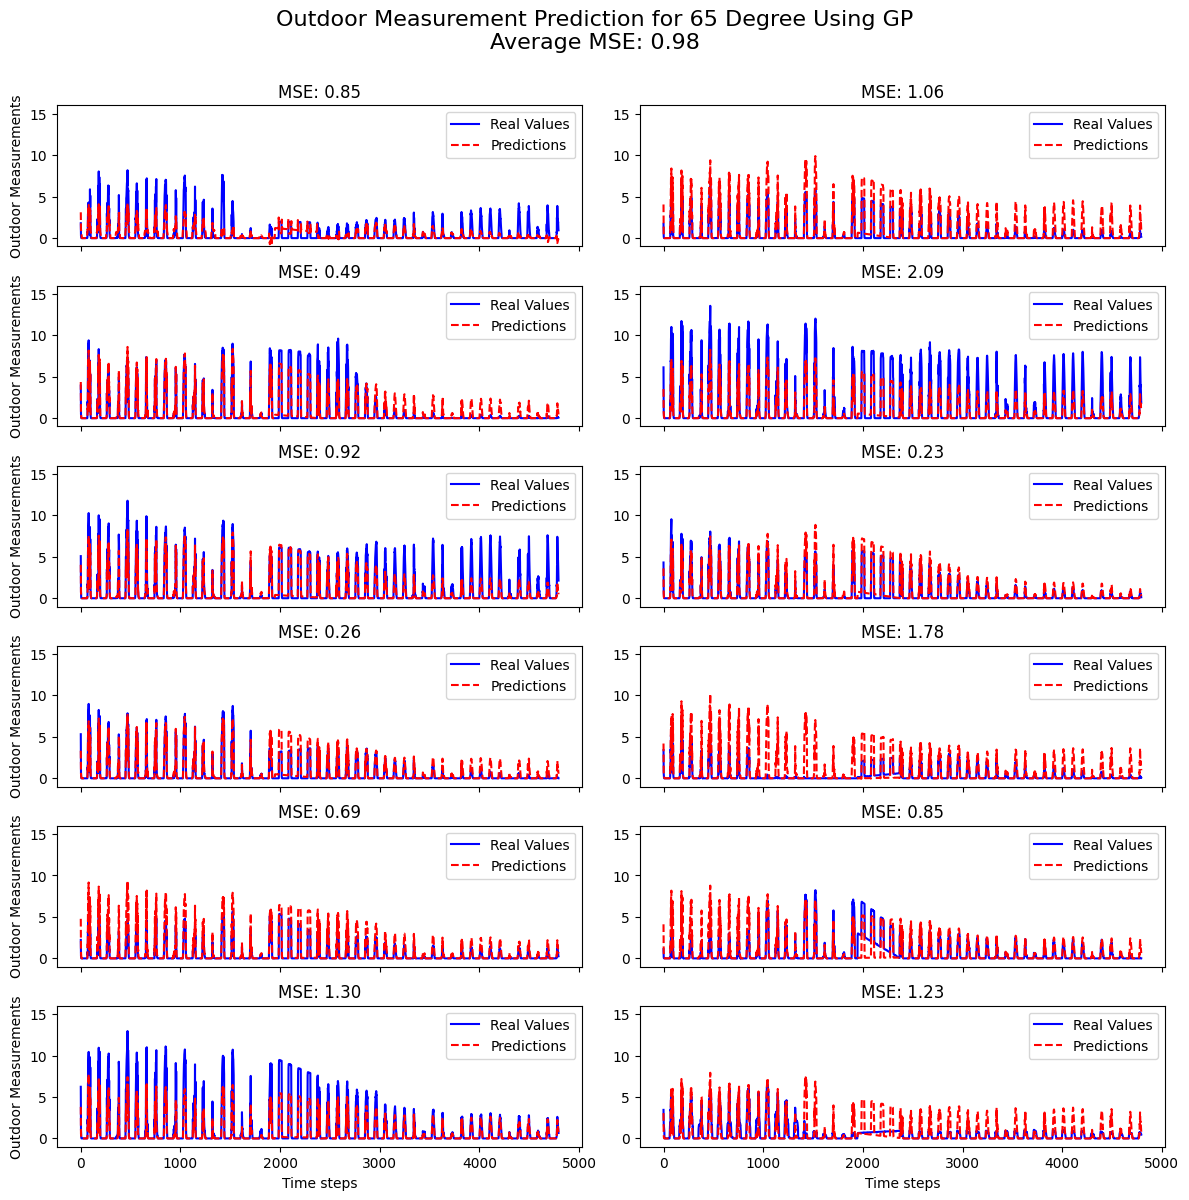

In [9]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 2, figsize=(12, 12), sharex=True)


for fold in range(6):
  
    y_pred_fold1 = predictions1[fold].squeeze()  
    y_pred_fold2 = predictions2[fold].squeeze()
    y_test_fold1 = test1[fold].squeeze()
    y_test_fold2 = test2[fold].squeeze()

    axes[fold, 0].plot(y_test_fold1, label='Real Values', color='blue')
    axes[fold, 0].plot(y_pred_fold1, label='Predictions', color='red',linestyle='dashed')
    axes[fold, 0].set_ylabel('Outdoor Measurements')
     
    axes[fold, 0].set_title(f'MSE: {average_mse_scores1[fold]:.2f}')
    axes[fold, 0].legend()
    axes[fold, 0].set_ylim(-1, 16)
   
    axes[fold, 1].plot(y_test_fold2, label='Real Values', color='blue')
    axes[fold, 1].plot(y_pred_fold2, label='Predictions', color='red',linestyle='dashed')
     
    axes[fold, 1].set_title(f'MSE: {average_mse_scores2[fold]:.2f}') 
    axes[fold, 1].legend()
    axes[fold, 1].set_ylim(-1, 16)

plt.tight_layout()
average_mse_all = (average_mse1+average_mse2)/2
axes[-1, 0].set_xlabel('Time steps')
axes[-1, 1].set_xlabel('Time steps')
fig.suptitle(f'Outdoor Measurement Prediction for 65 Degree Using GP\nAverage MSE: {average_mse_all:.2f}', fontsize=16)
fig.subplots_adjust(top=0.9)
plt.savefig('65 degree using GP.pdf')
plt.savefig('65 degree using GP.png')
plt.show()